In [1]:
#import necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve,precision_recall_curve,auc,f1_score

In [2]:
#read the data
df_X = pd.read_csv('sequence-bs-features.txt', delimiter='\s+', header=0) 
df_Y = pd.read_csv('gene-gomatrix.txt', delimiter='\s+', header=0)
predicted = pd.read_csv('final-predictions-human copy.txt', delimiter='\s+', header=0, on_bad_lines = 'skip')
predicted.index = predicted.index + 1

In [3]:
df_X.head()

,q3dna,q3carb,q3atp,q3ppi,q3rna,top5dna,top5carb,top5atp,top5ppi,top5rna,...,countN,countP,countQ,countR,countS,countT,countV,countW,countY,sqsize
P31946,0.310625,0.185669,0.103394,0.346282,0.015200,0.7790,0.625905,0.176510,0.503740,0.070297,...,0.056911,0.020325,0.060976,0.040650,0.077236,0.048780,0.044715,0.008130,0.044715,2.390935
P62258,0.311250,0.168360,0.114797,0.349137,0.016576,0.8475,0.649310,0.156503,0.493863,0.074668,...,0.043137,0.019608,0.035294,0.054902,0.054902,0.039216,0.050980,0.007843,0.047059,2.406540
Q04917,0.459375,0.155227,0.129250,0.335464,0.018188,0.8805,0.660605,0.160915,0.457920,0.091139,...,0.056911,0.016260,0.052846,0.048780,0.069106,0.032520,0.052846,0.008130,0.048780,2.390935
P61981,0.320000,0.189556,0.113903,0.345894,0.016431,0.8315,0.564121,0.175618,0.482345,0.076959,...,0.056680,0.016194,0.048583,0.052632,0.072874,0.044534,0.060729,0.008097,0.056680,2.392697
P31947,0.501250,0.113197,0.144869,0.353664,0.017850,0.9150,0.618908,0.169927,0.454528,0.068090,...,0.032258,0.028226,0.036290,0.052419,0.076613,0.040323,0.048387,0.008065,0.040323,2.394452


In [4]:
df_Y.head()

,GO:0003674,GO:0005576,GO:0005615,GO:0008150,GO:0070062,GO:0000166,GO:0003676,GO:0003723,GO:0005515,GO:0005654,...,GO:0045892,GO:0003924,GO:0000122,GO:0004871,GO:0043565,GO:0006367,GO:0016567,GO:0004842,GO:0034220,GO:0005874
A1BG,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1CF,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2BP1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2LD1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
#mapped sequence between protein and genes.
predicted.head()

,Gene,Protein,pred.seq,pred.ge,cons1,cons2,desall.g,desall.p
1,FOXA2,Q9Y261,0.517361,0.122593,6.342503,0.517361,1,1
2,FOXL2,P58012,0.491874,0.098542,4.847039,0.491874,1,1
3,HOXA13,P31271,0.483384,0.191965,9.279254,0.483384,1,1
4,HOXA3,O43365,0.461362,0.149816,6.911944,0.461362,1,1
5,FOXA1,P55317,0.457259,0.052730,2.411128,0.457259,1,1


DATA PREPROCESSING 

In [6]:
#droping unwanted columns as we only need gene and proteins
columns_to_drop = ['pred.seq', 'pred.ge', 'cons1', 'cons2', 'desall.g','desall.p']
predicted_new = predicted.drop(columns = columns_to_drop)
predicted_new.head()

,Gene,Protein
1,FOXA2,Q9Y261
2,FOXL2,P58012
3,HOXA13,P31271
4,HOXA3,O43365
5,FOXA1,P55317


In [7]:
# we need to check the index of Y and X 
index_Y = df_Y.index
print(index_Y)

Index(['A1BG', 'A1CF', 'A2BP1', 'A2LD1', 'A2M', 'A2ML1', 'A4GALT', 'A4GNT',
       'AAA1', 'AAAS',
       ...
       'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX',
       'ZZEF', 'ZZZ3'],
      dtype='object', length=20318)


In [8]:
print(df_X.columns)

Index(['q3dna', 'q3carb', 'q3atp', 'q3ppi', 'q3rna', 'top5dna', 'top5carb',
       'top5atp', 'top5ppi', 'top5rna', 'top10dna', 'top10carb', 'top10atp',
       'top10ppi', 'top10rna', 'top25dna', 'top25carb', 'top25atp', 'top25ppi',
       'top25rna', 'countA', 'countC', 'countD', 'countE', 'countF', 'countG',
       'countH', 'countI', 'countK', 'countL', 'countM', 'countN', 'countP',
       'countQ', 'countR', 'countS', 'countT', 'countV', 'countW', 'countY',
       'sqsize'],
      dtype='object')


In [9]:
print(df_Y.columns)

Index(['GO:0003674', 'GO:0005576', 'GO:0005615', 'GO:0008150', 'GO:0070062',
       'GO:0000166', 'GO:0003676', 'GO:0003723', 'GO:0005515', 'GO:0005654',
       ...
       'GO:0045892', 'GO:0003924', 'GO:0000122', 'GO:0004871', 'GO:0043565',
       'GO:0006367', 'GO:0016567', 'GO:0004842', 'GO:0034220', 'GO:0005874'],
      dtype='object', length=138)


In [10]:
#checking for any missing values 
missing_values = df_X.isna().sum()
print(missing_values)

q3dna        0
q3carb       0
q3atp        0
q3ppi        0
q3rna        0
top5dna      0
top5carb     0
top5atp      0
top5ppi      0
top5rna      0
top10dna     0
top10carb    0
top10atp     0
top10ppi     0
top10rna     0
top25dna     0
top25carb    0
top25atp     0
top25ppi     0
top25rna     0
countA       0
countC       0
countD       0
countE       0
countF       0
countG       0
countH       0
countI       0
countK       0
countL       0
countM       0
countN       0
countP       0
countQ       0
countR       0
countS       0
countT       0
countV       0
countW       0
countY       0
sqsize       0
dtype: int64


In [11]:
#checking for any missing values 
missing_values = df_Y.isna().sum()
print(missing_values)

GO:0003674    1
GO:0005576    1
GO:0005615    1
GO:0008150    1
GO:0070062    1
             ..
GO:0006367    1
GO:0016567    1
GO:0004842    1
GO:0034220    1
GO:0005874    1
Length: 138, dtype: int64


In [12]:
missing_values = predicted_new.isna().sum()
print(missing_values)

Gene       0
Protein    0
dtype: int64


FEATURE EXTRACTION 

In [13]:
# Calculating the sum of 1 in Y and creating a new column, this is done to reduce the unwanted data and retain only the useful data
df_Y['Sum'] = df_Y.iloc[:, :-1].sum(axis=1)
filtered_df_Y = df_Y[df_Y['Sum'] >= 3]
print(filtered_df_Y.iloc[:, -1])
filtered_df_Y.info()
#filtered_df_Y = filtered_df_Y.drop(columns='Sum')

A1BG      5.0
A1CF      8.0
A2M      10.0
A4GNT     4.0
AAAS     17.0
         ... 
ZXDA      7.0
ZXDB      7.0
ZXDC      8.0
ZYX      12.0
ZZZ3     10.0
Name: Sum, Length: 12504, dtype: float64
<class 'pandas.core.frame.DataFrame'>
Index: 12504 entries, A1BG to ZZZ3
Columns: 139 entries, GO:0003674 to Sum
dtypes: float64(139)
memory usage: 13.4+ MB


In [16]:
genes = predicted_new['Gene']
#checking for genes
index_Y1 = filtered_df_Y.index 
gene1 = genes
geneY = index_Y1 
common_indices_1 = list(gene1[gene1.isin(geneY)].index)
common_genes = genes.loc[common_indices_1]
unmatched_genes = genes[~genes.index.isin(common_indices_1)]
print(common_genes) 

1         FOXA2
2         FOXL2
3        HOXA13
4         HOXA3
5         FOXA1
          ...  
15679      PRNP
15680     CCL22
15681    NDUFB1
15682    PSENEN
15683     TCL1A
Name: Gene, Length: 12517, dtype: object


In [17]:
#matching the common genes to the predicted data to retrive the mappign proteins 
matching_proteins = predicted_new[predicted_new['Gene'].isin(common_genes)]
matching_proteins_without_genes = matching_proteins.drop(columns=['Gene'])
print(matching_proteins)
#see the dimension of common_genes and matching_proteins are same

         Gene Protein
1       FOXA2  Q9Y261
2       FOXL2  P58012
3      HOXA13  P31271
4       HOXA3  O43365
5       FOXA1  P55317
...       ...     ...
15679    PRNP  F7VJQ1
15680   CCL22  O00626
15681  NDUFB1  O75438
15682  PSENEN  Q9NZ42
15683   TCL1A  P56279

[12517 rows x 2 columns]


In [18]:
#the index of X has proteins, printing to check if the right command is used.
index_X1 = df_X.index 
print(index_X1)

Index(['P31946', 'P62258', 'Q04917', 'P61981', 'P31947', 'P27348', 'P63104',
       'P30443', 'P01892', 'P04439',
       ...
       'Q9H900', 'O95229', 'P98168', 'P98169', 'Q2QGD7', 'Q6WRX3', 'Q9C0D3',
       'Q15942', 'O43149', 'Q8IYH5'],
      dtype='object', length=20177)


In [19]:
#extracting common proteins
protein2 = matching_proteins_without_genes
common_proteins = protein2[protein2['Protein'].isin(index_X1)]
uncommon_proteins = protein2[~protein2['Protein'].isin(index_X1)]

print(common_proteins)

      Protein
1      Q9Y261
2      P58012
3      P31271
4      O43365
5      P55317
...       ...
15679  F7VJQ1
15680  O00626
15681  O75438
15682  Q9NZ42
15683  P56279

[12517 rows x 1 columns]


All genes and proteins are matched with the dataset. Both matching shows 0 unmatched proteins and genes.

In [20]:
# Extract the list of proteins from 'common_proteins'
common_proteins_list = common_proteins['Protein'].tolist()

# Filter the 'df_X' dataset for rows where the 'Protein' column matches the proteins in 'common_proteins'
filtered_df_X = df_X[df_X.index.isin(common_proteins_list)]  # Assuming 'df_X' has a 'Protein' index

print(filtered_df_X)

           q3dna    q3carb     q3atp     q3ppi     q3rna  top5dna  top5carb  \
P31946  0.310625  0.185669  0.103394  0.346282  0.015200   0.7790  0.625905   
P62258  0.311250  0.168360  0.114797  0.349137  0.016576   0.8475  0.649310   
Q04917  0.459375  0.155227  0.129250  0.335464  0.018188   0.8805  0.660605   
P61981  0.320000  0.189556  0.113903  0.345894  0.016431   0.8315  0.564121   
P31947  0.501250  0.113197  0.144869  0.353664  0.017850   0.9150  0.618908   
...          ...       ...       ...       ...       ...      ...       ...   
P98168  0.453750  0.050854  0.130541  0.396634  0.009704   0.8825  0.448144   
P98169  0.455000  0.051305  0.130560  0.399533  0.009704   0.8820  0.458804   
Q2QGD7  0.495000  0.046613  0.128091  0.409245  0.009704   0.9155  0.452073   
Q15942  0.425000  0.060512  0.122325  0.400090  0.009885   0.9035  0.590263   
Q8IYH5  0.420000  0.050573  0.117857  0.407653  0.009692   0.9065  0.365448   

         top5atp   top5ppi   top5rna  ...    countN

In [25]:
#these are the GO terms 
print(filtered_df_Y.columns)

Index(['GO:0003674', 'GO:0005576', 'GO:0005615', 'GO:0008150', 'GO:0070062',
       'GO:0000166', 'GO:0003676', 'GO:0003723', 'GO:0005515', 'GO:0005654',
       ...
       'GO:0003924', 'GO:0000122', 'GO:0004871', 'GO:0043565', 'GO:0006367',
       'GO:0016567', 'GO:0004842', 'GO:0034220', 'GO:0005874', 'Sum'],
      dtype='object', length=139)


In [26]:
#trying out for one value
#looking for the 1st protein value 
value_to_find = filtered_df_X.index[0]
column_name_1 = 'Protein'
# make a boolean mask for the location of the value
mask = matching_proteins[column_name_1] == value_to_find

# Check if the value exists in predicted
if mask.any():
    # Get the location of the value
    location = matching_proteins[mask].index[0], column_name_1
    print(f"Value '{value_to_find}' found at location: {location}")
else:
    print(f"Value '{value_to_find}' not found in 'predicted' dataset.")
    
#Get the row 
row_number, column_name_1 = location

gene_associated = matching_proteins.loc[row_number, 'Gene']

print(f"The gene associated with the protein {value_to_find} is: {gene_associated}")


Value 'P31946' found at location: (7142, 'Protein')
The gene associated with the protein P31946 is: YWHAB


In [27]:
values = []
genes = []  

for value_to_find in filtered_df_X.index:
    # Create a boolean mask for the location of the value in 'matching_proteins'
    mask = matching_proteins['Protein'] == value_to_find
    
    # Check if the value exists in 'matching_proteins'
    if mask.any():
        # Get the location of the value
        location = matching_proteins[mask].index[0]
        
        # Get the gene associated with the protein
        gene_associated = matching_proteins.loc[location, 'Gene']
        
        # Store the value and associated gene in separate lists
        values.append(value_to_find)
        genes.append(gene_associated)
    else:
        # If the value isn't found, store None or any default value in both lists
        values.append(value_to_find)
        genes.append(None)  # Or set it to a default value

values_and_genes = list(zip(values, genes))

In [28]:
# Check if any tuple contains a 'None' value
#making sure no none value 
none_present = any(None in tup for tup in values_and_genes)

if none_present:
    print("At least one tuple contains a 'None' value.")
else:
    print("No 'None' values found in tuples.")


No 'None' values found in tuples.


In [29]:
column_1 = filtered_df_Y.iloc[:, 0]
print(column_1)

A1BG     1.0
A1CF     0.0
A2M      0.0
A4GNT    0.0
AAAS     1.0
        ... 
ZXDA     0.0
ZXDB     1.0
ZXDC     0.0
ZYX      0.0
ZZZ3     0.0
Name: GO:0003674, Length: 12504, dtype: float64


In [30]:
print(filtered_df_X.index)

Index(['P31946', 'P62258', 'Q04917', 'P61981', 'P31947', 'P27348', 'P63104',
       'P30443', 'P04439', 'P01889',
       ...
       'Q8NEG5', 'Q19AV6', 'O43264', 'Q9H900', 'O95229', 'P98168', 'P98169',
       'Q2QGD7', 'Q15942', 'Q8IYH5'],
      dtype='object', length=12504)


In [31]:
common_proteins2 = filtered_df_X.index.intersection(matching_proteins['Protein'])

filtered_df_X = filtered_df_X.loc[common_proteins_list].drop_duplicates()
matching_proteins_dropped_duplicates = matching_proteins[matching_proteins['Protein'].isin(common_proteins2)].drop_duplicates(subset='Protein')

# Arrange matching_proteins based on the index of filtered_df_X
matching_proteins2 = matching_proteins_dropped_duplicates.set_index('Protein').loc[filtered_df_X.index].reset_index()

print(filtered_df_X)

           q3dna    q3carb     q3atp     q3ppi     q3rna  top5dna  top5carb  \
Q9Y261  0.425000  0.111431  0.128269  0.378110  0.014373   0.8665  0.558836   
P58012  0.511250  0.103593  0.132917  0.376940  0.021208   0.8805  0.655053   
P31271  0.480000  0.110199  0.129364  0.383290  0.017849   0.8700  0.593949   
O43365  0.502500  0.076207  0.129867  0.384746  0.014981   0.8765  0.495063   
P55317  0.452500  0.106916  0.129924  0.381331  0.015033   0.8770  0.541659   
...          ...       ...       ...       ...       ...      ...       ...   
F7VJQ1  0.640000  0.525451  0.150363  0.404775  0.049084   0.8415  0.889300   
O00626  0.397500  0.109026  0.135152  0.411596  0.026502   0.8460  0.553895   
O75438  0.323125  0.155844  0.138801  0.400135  0.025632   0.7750  0.503216   
Q9NZ42  0.417500  0.179703  0.149878  0.413406  0.025306   0.8465  0.646778   
P56279  0.363125  0.094064  0.134547  0.385972  0.026903   0.8190  0.559921   

         top5atp   top5ppi   top5rna  ...    countN

In [32]:
print(df_Y.columns)

Index(['GO:0003674', 'GO:0005576', 'GO:0005615', 'GO:0008150', 'GO:0070062',
       'GO:0000166', 'GO:0003676', 'GO:0003723', 'GO:0005515', 'GO:0005654',
       ...
       'GO:0003924', 'GO:0000122', 'GO:0004871', 'GO:0043565', 'GO:0006367',
       'GO:0016567', 'GO:0004842', 'GO:0034220', 'GO:0005874', 'Sum'],
      dtype='object', length=139)


In [33]:
columns_dict = {}

for i, column in enumerate(df_Y.columns, 1):
    column_name = f"column_{i}"
    columns_dict[column_name] = df_Y[column]

In [34]:
#column1 = filtered_df_Y['GO:0003674'] 
#trying for 1 value
arranged_column = columns_dict["column_1"].reindex(matching_proteins2['Gene']).values

print("Arranged column based on 'Gene' column of mapped dataset:")
print(arranged_column)

Arranged column based on 'Gene' column of mapped dataset:
[0. 0. 0. ... 0. 0. 0.]


In [35]:
arranged_columns = {}  # Dictionary to store the reindexed columns

for i in range(1, 139): #last column is sum column 
    column_name = f"column_{i}"
    if column_name in columns_dict:
        arranged_columns[column_name] = columns_dict[column_name].reindex(matching_proteins2['Gene']).values
    else:
        print(f"Column {column_name} not found in columns_dict.")

# Printing or using the arranged columns
for column_name, arranged_column in arranged_columns.items():
    print(f"Arranged Column: {column_name}")
    print(arranged_column)

Arranged Column: column_1
[0. 0. 0. ... 0. 0. 0.]
Arranged Column: column_2
[0. 0. 0. ... 0. 0. 0.]
Arranged Column: column_3
[0. 0. 0. ... 0. 0. 0.]
Arranged Column: column_4
[0. 0. 0. ... 0. 0. 0.]
Arranged Column: column_5
[0. 0. 0. ... 1. 0. 0.]
Arranged Column: column_6
[0. 0. 0. ... 0. 0. 0.]
Arranged Column: column_7
[0. 0. 0. ... 0. 0. 0.]
Arranged Column: column_8
[0. 0. 0. ... 0. 0. 0.]
Arranged Column: column_9
[0. 1. 0. ... 0. 1. 1.]
Arranged Column: column_10
[0. 0. 1. ... 0. 0. 0.]
Arranged Column: column_11
[1. 0. 0. ... 0. 0. 0.]
Arranged Column: column_12
[0. 0. 0. ... 0. 1. 1.]
Arranged Column: column_13
[0. 0. 0. ... 0. 0. 0.]
Arranged Column: column_14
[0. 0. 0. ... 0. 0. 0.]
Arranged Column: column_15
[0. 0. 0. ... 0. 0. 0.]
Arranged Column: column_16
[0. 0. 0. ... 0. 0. 0.]
Arranged Column: column_17
[0. 0. 0. ... 0. 0. 0.]
Arranged Column: column_18
[0. 0. 0. ... 0. 0. 0.]
Arranged Column: column_19
[0. 0. 0. ... 0. 0. 0.]
Arranged Column: column_20
[0. 0. 0. ...

In [36]:
data_1 = pd.Series(arranged_columns['column_1'], index=filtered_df_X.index, name = filtered_df_Y.columns[0])

result_data_1 = pd.concat([filtered_df_X, data_1],axis = 1)

In [37]:
result_data_dict = {}

for i in range(1,139):
    column_name = f'column_{i}'
    if column_name in arranged_columns:
        data_i = pd.Series(arranged_columns[column_name], index=filtered_df_X.index, name = filtered_df_Y.columns[i - 1])
        result_data_i = pd.concat([filtered_df_X, data_i],axis = 1)
        result_data_dict[f"result_data_{i}"] = result_data_i
#print(result_data_dict.keys())
#print(result_data_dict['result_data_3'])

MODEL 

In [38]:
#for a single dataset 
X1 = result_data_dict['result_data_1'].drop('GO:0003674', axis=1) 
y1 = result_data_dict['result_data_1']['GO:0003674']

X_train, X_test, y_train, y_test = train_test_split( X1,y1, test_size=0.2, random_state=42) 

logistic_regression = LogisticRegression()

logistic_regression.fit(X_train, y_train)

predictions = logistic_regression.predict(X_test)
print(predictions)

accuracy_train = logistic_regression.score(X_train,y_train)
print(f"Accuracy of the logistic regression model for train data: {accuracy_train}")

accuracy_test = logistic_regression.score(X_test, y_test)
print(f"Accuracy of the logistic regression model for test data: {accuracy_test}")


[0. 0. 0. ... 0. 0. 0.]
Accuracy of the logistic regression model for train data: 0.9564825930372148
Accuracy of the logistic regression model for test data: 0.9604


In [39]:
# Loop through columns
for i in range(1, 139):
    # Drop the last column from X and assign X1, and select the last column for y1
    last_column_index = -1  # Index of the last column
    X1 = result_data_dict[f'result_data_{i}'].iloc[:, :-1]  # Dropping the last column
    y1 = result_data_dict[f'result_data_{i}'].iloc[:, last_column_index]  # Selecting the last column as y

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

    # Initialize Logistic Regression model
    logistic_regression = LogisticRegression(max_iter=1000)

    # Fit the model
    model = logistic_regression.fit(X_train, y_train)

    # Make predictions
    predictions = logistic_regression.predict(X_test)
    print(f"Predictions for result_data_{i}: {predictions}")

    # Calculate accuracy for train data
    accuracy_train = logistic_regression.score(X_train, y_train)
    print(f"Accuracy of the logistic regression model for train data for result_data_{i}: {accuracy_train}")

    # Calculate accuracy for test data
    accuracy_test = logistic_regression.score(X_test, y_test)
    print(f"Accuracy of the logistic regression model for test data for result_data_{i}: {accuracy_test}")


Predictions for result_data_1: [0. 0. 0. ... 0. 0. 0.]
Accuracy of the logistic regression model for train data for result_data_1: 0.9564825930372148
Accuracy of the logistic regression model for test data for result_data_1: 0.9604
Predictions for result_data_2: [0. 0. 0. ... 0. 0. 0.]
Accuracy of the logistic regression model for train data for result_data_2: 0.9199679871948779
Accuracy of the logistic regression model for test data for result_data_2: 0.93
Predictions for result_data_3: [0. 0. 0. ... 0. 0. 0.]
Accuracy of the logistic regression model for train data for result_data_3: 0.921468587434974
Accuracy of the logistic regression model for test data for result_data_3: 0.9216
Predictions for result_data_4: [0. 0. 0. ... 0. 0. 0.]
Accuracy of the logistic regression model for train data for result_data_4: 0.9592837134853942
Accuracy of the logistic regression model for test data for result_data_4: 0.9692
Predictions for result_data_5: [0. 0. 0. ... 0. 0. 0.]
Accuracy of the logi

In [41]:
#KFold cross validation techquine - 5:2 fold model 

for i in range(1, 139):
    X = result_data_dict[f'result_data_{i}'].iloc[:, :-1]  # Features
    y = result_data_dict[f'result_data_{i}'].iloc[:, -1]  # Target

    for _ in range(2):
        kf_outer = KFold(n_splits=5, shuffle=True, random_state=42) 
        accuracies = []

        for train_index, test_index in kf_outer.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            kf_inner = KFold(n_splits=5, shuffle=True, random_state=42) 

            fold_accuracies = [] 

            # Inner loop
            for inner_train_index, inner_test_index in kf_inner.split(X_train):
                X_inner_train, X_inner_test = X_train.iloc[inner_train_index], X_train.iloc[inner_test_index]
                y_inner_train, y_inner_test = y_train.iloc[inner_train_index], y_train.iloc[inner_test_index]

                # Model
                logistic_regression = LogisticRegression(max_iter=1000)

                logistic_regression.fit(X_inner_train, y_inner_train)

                predictions = logistic_regression.predict(X_inner_test)

                # fold accuracy
                fold_accuracy = accuracy_score(y_inner_test, predictions)
                fold_accuracies.append(fold_accuracy)

            #inner loop
            average_fold_accuracy = sum(fold_accuracies) / len(fold_accuracies)
            accuracies.append(average_fold_accuracy)

    # outer loop
    average_accuracy2 = sum(accuracies) / len(accuracies)
    round_accuracy2 = round(average_accuracy2,3)
    print(f"Average accuracy for result_data_{i} after 5:2 cross-validation: {round_accuracy2}")


Average accuracy for result_data_1 after 5:2 cross-validation: 0.957
Average accuracy for result_data_2 after 5:2 cross-validation: 0.922
Average accuracy for result_data_3 after 5:2 cross-validation: 0.922
Average accuracy for result_data_4 after 5:2 cross-validation: 0.961
Average accuracy for result_data_5 after 5:2 cross-validation: 0.813
Average accuracy for result_data_6 after 5:2 cross-validation: 0.982
Average accuracy for result_data_7 after 5:2 cross-validation: 0.984
Average accuracy for result_data_8 after 5:2 cross-validation: 0.975
Average accuracy for result_data_9 after 5:2 cross-validation: 0.619
Average accuracy for result_data_10 after 5:2 cross-validation: 0.819
Average accuracy for result_data_11 after 5:2 cross-validation: 0.681
Average accuracy for result_data_12 after 5:2 cross-validation: 0.948
Average accuracy for result_data_13 after 5:2 cross-validation: 0.939
Average accuracy for result_data_14 after 5:2 cross-validation: 0.976
Average accuracy for result_d

Logistics : ROC AUC = 0.740


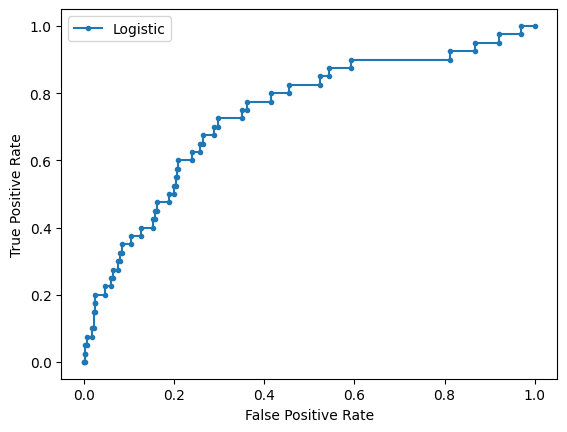

In [42]:
#implementation of ROC curve 
ns_probs = [0 for _ in range(len(y_test))]
#predict probabilities
lr_probs = model.predict_proba(X_test)
#keeping probabilities for positive outcomes only
lr_probs= lr_probs[:,1]
# predict class values
class_val = model.predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, class_val), auc(lr_recall, lr_precision)
#calculate scores
lr_auc = roc_auc_score(y_test, lr_probs)
#auc score 
print('Logistics : ROC AUC = %.3f' % (lr_auc))
#calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_test,lr_probs)
#plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker = '.', label = 'Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()